In [1]:
import os
import tifffile as tif
import numpy as np
import napari
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# change settings to show all columns in a dataframe
pd.set_option('display.max_columns', None)

# ignore napari warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # create napari viewer instance
    viewer = napari.Viewer() 

> **Note**: notebook *4_quantitative_measurements* needs to be run again for a different compound before starting this one.

In [2]:
path = "/Users/laura/projects/Bio-image_analysis_school_ScadsAI/prepared_dataset"

nuclei_labels_path = os.path.join(path, "labels_nuclei")
actin_labels_path = os.path.join(path, "labels_actin")
tubulin_labels_path = os.path.join(path, "labels_tubulin")

In [3]:
os.listdir(path)

['aphidicolin_timelapse.tif',
 '.DS_Store',
 'nocodazole_timelapse.tif',
 'AZ-I_timelapse.tif',
 'taxol_timelapse.tif',
 'labels_nuclei',
 'latrunculin B_timelapse.tif',
 'epothilone B_timelapse.tif',
 'monastrol_timelapse.tif',
 'AZ-H_timelapse.tif',
 'DMSO_timelapse.tif',
 'colchicine_timelapse.tif',
 'doxorubicin_timelapse.tif',
 'cytochalasin B_timelapse.tif',
 'labels_tubulin',
 'labels_actin',
 'AZ-A_timelapse.tif']

In [4]:
filename1 = "nocodazole_timelapse"
filename2 = "latrunculin B_timelapse"
filename_control= "DMSO_timelapse"

In [5]:
img1 = tif.imread(os.path.join(path, f'{filename1}.tif'))
img2 = tif.imread(os.path.join(path, f'{filename2}.tif'))

img_c = tif.imread(os.path.join(path, f'{filename_control}.tif'))

In [6]:
# load nuclei and actin segmentation
labels_nuclei1 = tif.imread(os.path.join(nuclei_labels_path, f'{filename1}_labels_dapi.tif'))
labels_actin1 = tif.imread(os.path.join(actin_labels_path, f'{filename1}_labels_actin.tif'))
labels_tubulin1 = tif.imread(os.path.join(tubulin_labels_path, f'{filename1}_labels_tubulin.tif'))

labels_nuclei2 = tif.imread(os.path.join(nuclei_labels_path, f'{filename2}_labels_dapi.tif'))
labels_actin2 = tif.imread(os.path.join(actin_labels_path, f'{filename2}_labels_actin.tif'))
labels_tubulin2 = tif.imread(os.path.join(tubulin_labels_path, f'{filename2}_labels_tubulin.tif'))

labels_nuclei_c = tif.imread(os.path.join(nuclei_labels_path, f'{filename_control}_labels_dapi.tif'))
labels_actin_c = tif.imread(os.path.join(actin_labels_path, f'{filename_control}_labels_actin.tif'))
labels_tubulin_c = tif.imread(os.path.join(tubulin_labels_path, f'{filename_control}_labels_tubulin.tif'))

In [7]:
img1 = img1[:, np.newaxis, :, :, :]

# do the same for all label images
labels_actin1 = labels_actin1[:, np.newaxis, :, :]
labels_nuclei1 = labels_nuclei1[:, np.newaxis, :, :]
labels_tubulin1 = labels_tubulin1[:, np.newaxis, :, :]

img2 = img2[:, np.newaxis, :, :, :]

# do the same for all label images
labels_actin2 = labels_actin2[:, np.newaxis, :, :]
labels_nuclei2 = labels_nuclei2[:, np.newaxis, :, :]
labels_tubulin2 = labels_tubulin2[:, np.newaxis, :, :]

img_c = img_c[:, np.newaxis, :, :, :]

# do the same for all label images
labels_actin_c = labels_actin_c[:, np.newaxis, :, :]
labels_nuclei_c = labels_nuclei_c[:, np.newaxis, :, :]
labels_tubulin_c = labels_tubulin_c[:, np.newaxis, :, :]

In [8]:
# since with napari-clusters-plotter we can use only image, we will combine both images into one timelapse, 
# where in timepoints 0-7 we have compound 1, in 8-15 timepoints we have compound 2, and in 16th control DMSO
print(f"Shape of the first image: {img1.shape}")
print(f"Shape of the second image: {img2.shape}")
print(f"Shape of the control image: {img_c.shape}")

# the shapes of both images need to be the same to combine them like this:
combined_timelapse = np.concatenate((img1, img2, img_c), axis=0)


Shape of the first image: (8, 1, 1024, 1280, 3)
Shape of the second image: (8, 1, 1024, 1280, 3)
Shape of the control image: (1, 1, 1024, 1280, 3)


In [9]:
# viewer.add_image(combined_timelapse) # and then in the viewer right click on the layer - split RGB or:
viewer.add_image(
    combined_timelapse,
    name=["tubulin", "actin", "nuclei"],
    colormap=["magenta", "green", "blue"],
    channel_axis=4)

[<Image layer 'tubulin' at 0x28f5bfe50>,
 <Image layer 'actin' at 0x1721b9fa0>,
 <Image layer 'nuclei' at 0x1721f9c70>]

In [10]:
# do the same for label images
combined_actin_labels = np.concatenate((labels_actin1, labels_actin2, labels_actin_c), axis=0)
combined_tubulin_labels = np.concatenate((labels_tubulin1, labels_tubulin2, labels_tubulin_c), axis=0)
combined_nuclei_labels = np.concatenate((labels_nuclei1, labels_nuclei2, labels_nuclei_c), axis=0)

In [11]:
# add segmentation layers to the viewer
viewer.add_labels(combined_actin_labels, name="actin_segmented")
viewer.add_labels(combined_nuclei_labels, name="nuclei_segmented")
viewer.add_labels(combined_tubulin_labels, name="tubulin_segmented")

<Labels layer 'tubulin_segmented' at 0x2f332ac40>

In [12]:
# load corresponding measurements csv
df1 = pd.read_csv(f'{filename1}_measurements.csv')
df2 = pd.read_csv(f'{filename2}_measurements.csv')
df_c = pd.read_csv(f'{filename_control}_measurements.csv')

In [13]:
# combine both measurements tables into one
offset = df1['frame'].max() + 1

# adjust frame column for the second compound
df2['frame'] += offset

# new offset for the control image, which is the last one
offset = df2['frame'].max() + 1
df_c['frame'] += offset

In [14]:
combined_df = pd.concat([df1, df2, df_c])

In [15]:
combined_df

,frame,label,area_dapi,equivalent_diameter_dapi,mean_intensity_dapi,min_intensity_dapi,max_intensity_dapi,perimeter_dapi,perimeter_crofton_dapi,extent_dapi,solidity_dapi,feret_diameter_max_dapi,major_axis_length_dapi,minor_axis_length_dapi,eccentricity_dapi,orientation_dapi,area_actin,equivalent_diameter_actin,mean_intensity_actin,min_intensity_actin,max_intensity_actin,perimeter_actin,perimeter_crofton_actin,extent_actin,solidity_actin,feret_diameter_max_actin,major_axis_length_actin,minor_axis_length_actin,eccentricity_actin,orientation_actin,area_tubulin,equivalent_diameter_tubulin,mean_intensity_tubulin,min_intensity_tubulin,max_intensity_tubulin,perimeter_tubulin,perimeter_crofton_tubulin,extent_tubulin,solidity_tubulin,feret_diameter_max_tubulin,major_axis_length_tubulin,minor_axis_length_tubulin,eccentricity_tubulin,orientation_tubulin
0,0,1,51.0,8.058239,0.167979,0.083643,0.254647,34.485281,35.375614,0.750000,0.944444,17.000000,16.699044,4.066449,0.969897,-1.564183,883.0,33.530143,0.119379,0.081159,0.192271,146.876154,144.414011,0.617051,0.899185,53.460266,50.832770,24.742622,0.873544,-1.468765,1478.0,43.380273,0.143015,0.029722,0.366054,206.917785,201.337046,0.565633,0.856812,70.519501,66.715717,34.099459,0.859512,1.318986
1,0,2,649.0,28.745999,0.165379,0.115242,0.210037,101.112698,98.542366,0.780048,0.941945,35.341194,34.562224,25.219399,0.683788,1.438942,1389.0,42.053891,0.155570,0.106280,0.219324,183.710678,177.242860,0.665230,0.871940,59.203040,56.035253,34.286886,0.790950,1.459215,2416.0,55.463021,0.100016,0.029331,0.238952,252.409163,242.765807,0.567136,0.865330,84.059503,79.006359,41.878135,0.847960,-0.483112
2,0,3,965.0,35.052477,0.178177,0.087361,0.250929,116.811183,113.425463,0.724474,0.971803,41.880783,41.374456,29.809831,0.693467,-0.855667,5343.0,82.479809,0.152169,0.045411,0.453140,557.830519,546.056318,0.466190,0.676244,159.840546,156.791723,56.600349,0.932569,-1.338031,3355.0,65.358386,0.140226,0.029331,0.383653,304.758405,294.881169,0.513468,0.862690,114.908659,94.147899,49.308249,0.851883,-0.998811
3,0,4,681.0,29.446156,0.190088,0.100372,0.327138,105.254834,102.469357,0.709375,0.935440,34.985711,30.833248,30.070002,0.221123,0.357786,1723.0,46.837931,0.192738,0.045411,0.591304,342.800036,328.820739,0.396457,0.471151,112.946890,111.582379,36.281730,0.945660,-1.458035,952.0,34.815572,0.165720,0.037544,0.412202,140.669048,136.044137,0.689855,0.878229,49.040799,46.718906,29.029679,0.783518,1.430018
4,0,5,176.0,14.969641,0.143112,0.117100,0.171004,56.627417,56.367675,0.666667,0.956522,24.083189,22.479143,11.103994,0.869480,-1.503134,468.0,24.410574,0.100213,0.079227,0.142995,98.805087,99.787840,0.609375,0.858716,34.928498,28.834912,22.419438,0.628870,-1.254344,1678.0,46.222245,0.098445,0.029331,0.338287,192.503571,186.168095,0.747772,0.853510,60.207973,49.546863,46.315471,0.355224,0.940611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,16,219,612.0,27.914559,0.228325,0.162602,0.294309,95.941125,93.639408,0.809524,0.977636,36.674242,36.376578,22.083566,0.794639,1.503317,5728.0,85.399743,0.059505,0.033823,0.086790,399.385822,383.482865,0.623965,0.863952,153.209008,138.180600,57.224254,0.910219,-1.561466,5159.0,81.047164,0.127046,0.029626,0.507514,412.421356,399.897290,0.630993,0.861413,146.030819,131.954569,54.136550,0.911966,-1.549621
219,16,220,501.0,25.256544,0.168067,0.123577,0.217886,88.041631,86.150217,0.824013,0.972816,32.984845,32.388596,20.667636,0.769941,-1.563516,2712.0,58.762451,0.071224,0.033823,0.180600,282.929978,271.112306,0.623448,0.768054,88.842557,79.161028,52.439570,0.749113,1.341769,2522.0,56.666658,0.135754,0.029626,0.385144,274.237590,265.193911,0.596217,0.795333,96.664368,81.256961,46.949464,0.816185,1.271864
220,16,221,260.0,18.194567,0.138030,0.099187,0.175610,72.627417,71.536626,0.738636,0.966543,32.062439,31.240097,11.340435,0.931786,-1.568107,160

In [16]:
# add measurements table to the properties of the tubulin labels layer
viewer.layers['tubulin_segmented'].properties = combined_df

Selected labels layer: tubulin_segmented
Selected measurements: ['area_dapi', 'equivalent_diameter_dapi', 'mean_intensity_dapi', 'min_intensity_dapi', 'max_intensity_dapi', 'perimeter_dapi', 'perimeter_crofton_dapi', 'extent_dapi', 'solidity_dapi', 'feret_diameter_max_dapi', 'major_axis_length_dapi', 'minor_axis_length_dapi', 'eccentricity_dapi', 'orientation_dapi', 'area_actin', 'equivalent_diameter_actin', 'mean_intensity_actin', 'min_intensity_actin', 'max_intensity_actin', 'perimeter_actin', 'perimeter_crofton_actin', 'extent_actin', 'solidity_actin', 'feret_diameter_max_actin', 'major_axis_length_actin', 'minor_axis_length_actin', 'eccentricity_actin', 'orientation_actin', 'area_tubulin', 'equivalent_diameter_tubulin', 'mean_intensity_tubulin', 'min_intensity_tubulin', 'max_intensity_tubulin', 'perimeter_tubulin', 'perimeter_crofton_tubulin', 'extent_tubulin', 'solidity_tubulin', 'feret_diameter_max_tubulin', 'major_axis_length_tubulin', 'minor_axis_length_tubulin', 'eccentricity_

/Users/laura/micromamba/envs/devbio-napari-env/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342
Dimensionality reduction finished


/Users/laura/micromamba/envs/devbio-napari-env/lib/python3.9/site-packages/napari/components/viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,
/Users/laura/micromamba/envs/devbio-napari-env/lib/python3.9/site-packages/napari/utils/_proxies.py:144: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  setattr(self.__wrapped__, name, value)
/Users/laura/micromamba/envs/devbio-napari-env/lib/python3.9/site-packages/napari/utils/_proxies.py:144: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  setattr(self.__wrapped__, name, value)

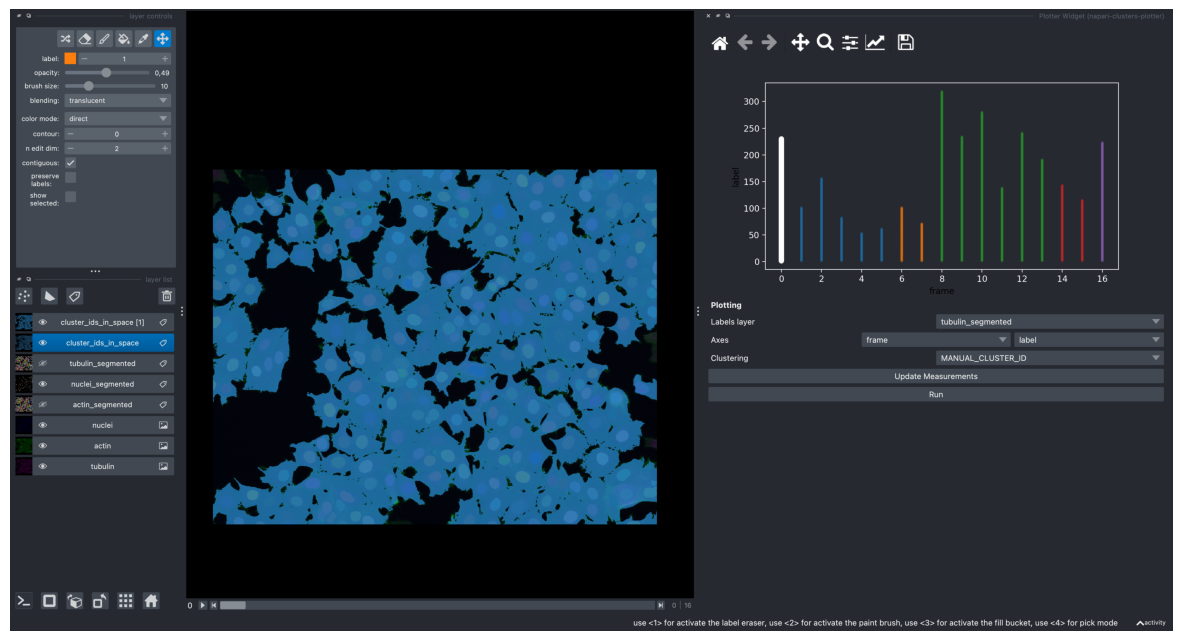

/Users/laura/micromamba/envs/devbio-napari-env/lib/python3.9/site-packages/napari/utils/_proxies.py:144: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  setattr(self.__wrapped__, name, value)


In [18]:
screenshot = viewer.screenshot(canvas_only=False)

plt.figure(figsize=(15, 10))
plt.imshow(screenshot)
plt.axis('off')
plt.show()

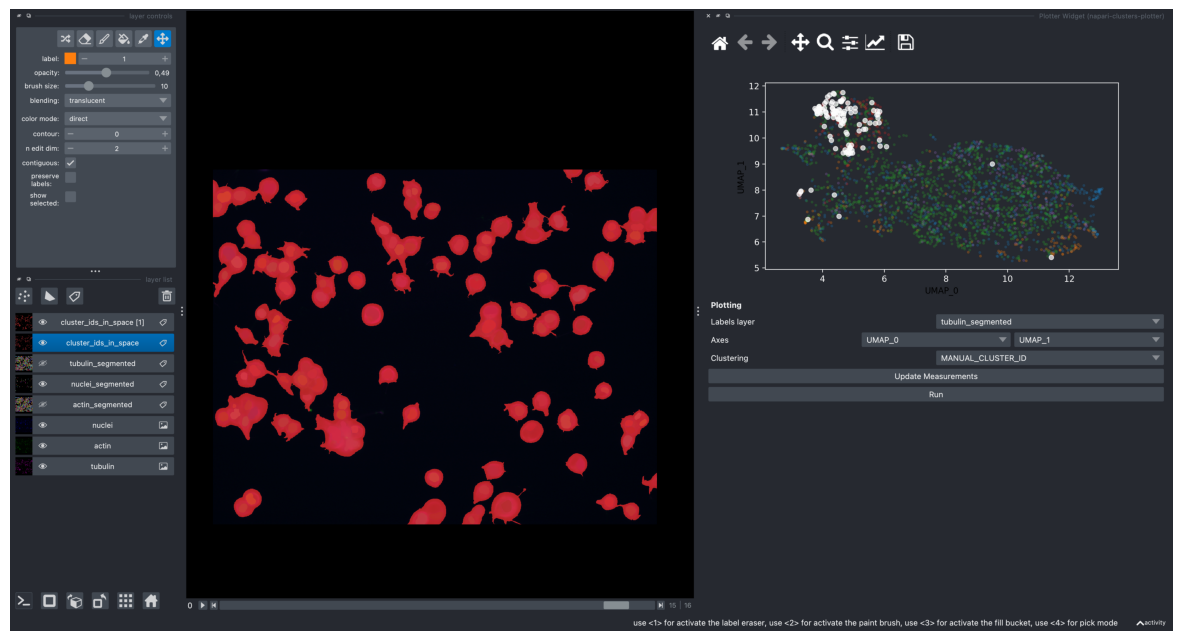

In [19]:
# UMAP with all of features
screenshot = viewer.screenshot(canvas_only=False)

plt.figure(figsize=(15, 10))
plt.imshow(screenshot)
plt.axis('off')
plt.show()

In [20]:
# get layer's properties containing UMAP results
df = pd.DataFrame(viewer.layers['tubulin_segmented'].properties)

In [21]:
from scipy.stats import spearmanr

correlations = {}

for column in df.columns:
    
    # don't compute correlation for these columns
    if column in ['label', 'frame', 'UMAP_0', 'UMAP_1', 't-SNE_0', 't-SNE_1', 'index'] or '_CLUSTER_ID' in column:
        continue
        
    corr = spearmanr(df[column], df['UMAP_1'])[0]
    correlations[column] = corr

# sort features based on the absolute value of correlation
sorted_features = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

for feature, correlation in sorted_features:
    print(f"{feature}: {correlation}")

major_axis_length_tubulin: -0.45427329839716024
eccentricity_tubulin: -0.435280176575601
feret_diameter_max_tubulin: -0.4336607627009672
major_axis_length_actin: -0.4291223605584224
eccentricity_actin: -0.41842276708710285
max_intensity_dapi: 0.4133006019709577
mean_intensity_dapi: 0.40984865036090656
extent_tubulin: 0.4016230410186044
feret_diameter_max_actin: -0.4005739702990752
perimeter_crofton_tubulin: -0.3536617596995489
perimeter_tubulin: -0.352592632881828
extent_actin: 0.3490281141459258
solidity_tubulin: 0.34162244893558275
mean_intensity_tubulin: 0.33198176347249264
perimeter_actin: -0.3278094544133843
perimeter_crofton_actin: -0.3254372727036644
solidity_actin: 0.3024339671147008
eccentricity_dapi: -0.2852678038740644
area_actin: -0.28342198005644476
equivalent_diameter_actin: -0.28342198005644476
max_intensity_tubulin: 0.27599778189154156
min_intensity_dapi: 0.2563386635720779
area_tubulin: -0.24361530735295392
equivalent_diameter_tubulin: -0.24361530735295392
extent_dapi:

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
/Users/laura/micromamba/envs/devbio-napari-env/lib/python3.9/site-packages/napari/components/viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,


#### k-Means Clustering
On most correlating 9 features

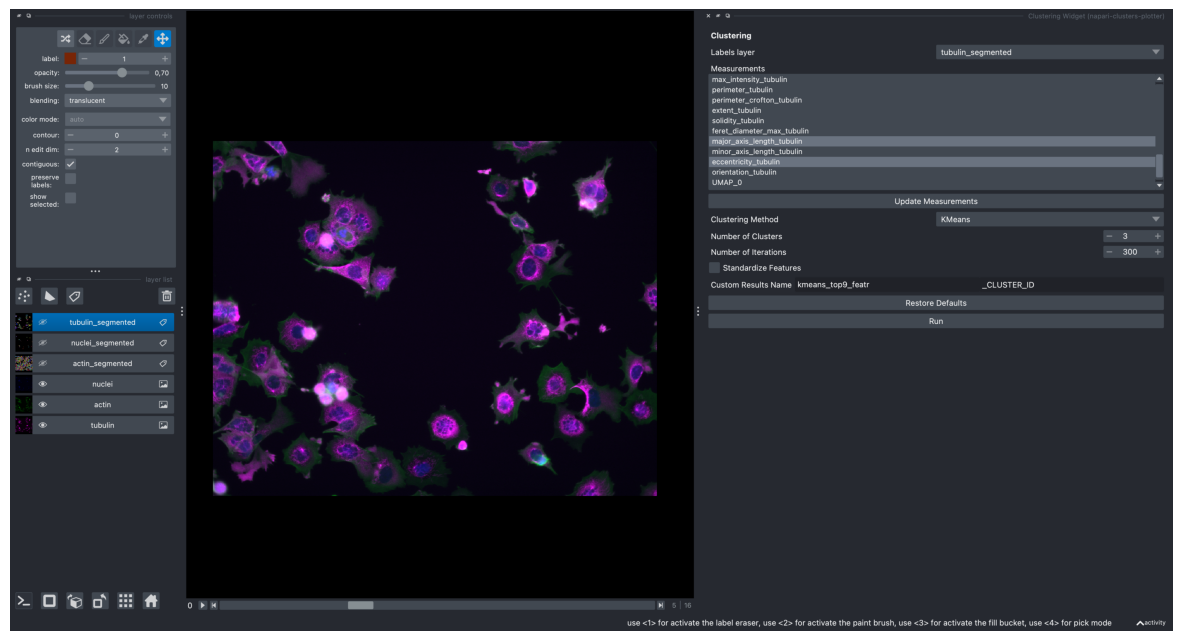

In [23]:
screenshot = viewer.screenshot(canvas_only=False)

plt.figure(figsize=(15, 10))
plt.imshow(screenshot)
plt.axis('off')
plt.show()

Plotting these clustering results on the obtained UMAP plot

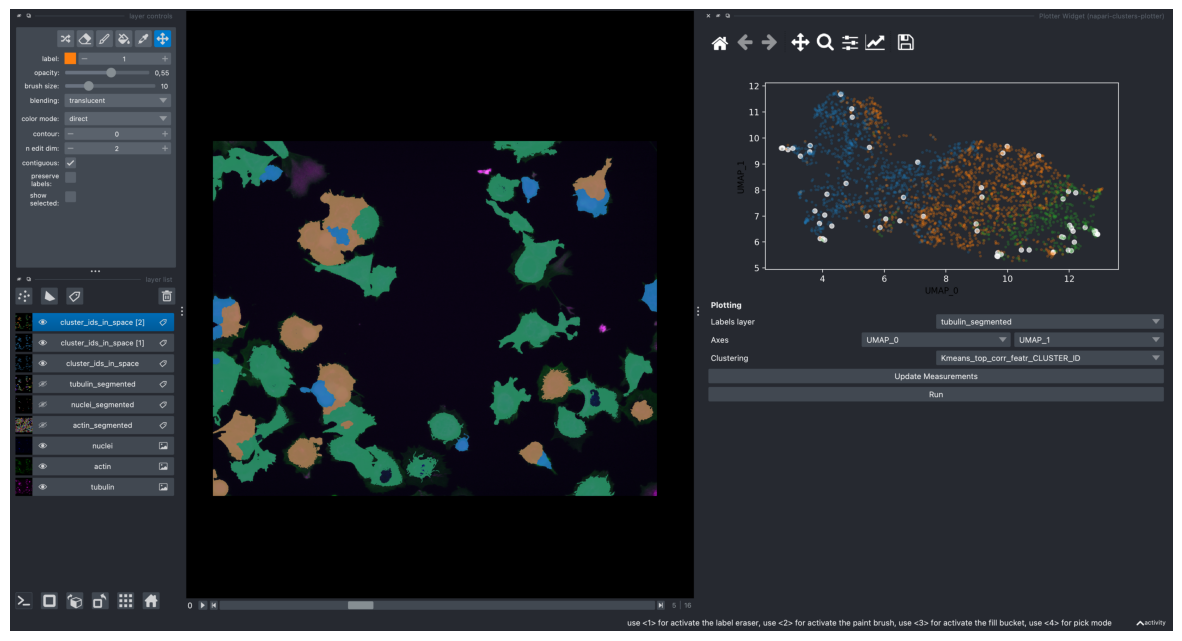

In [22]:
screenshot = viewer.screenshot(canvas_only=False)

plt.figure(figsize=(15, 10))
plt.imshow(screenshot)
plt.axis('off')
plt.show()

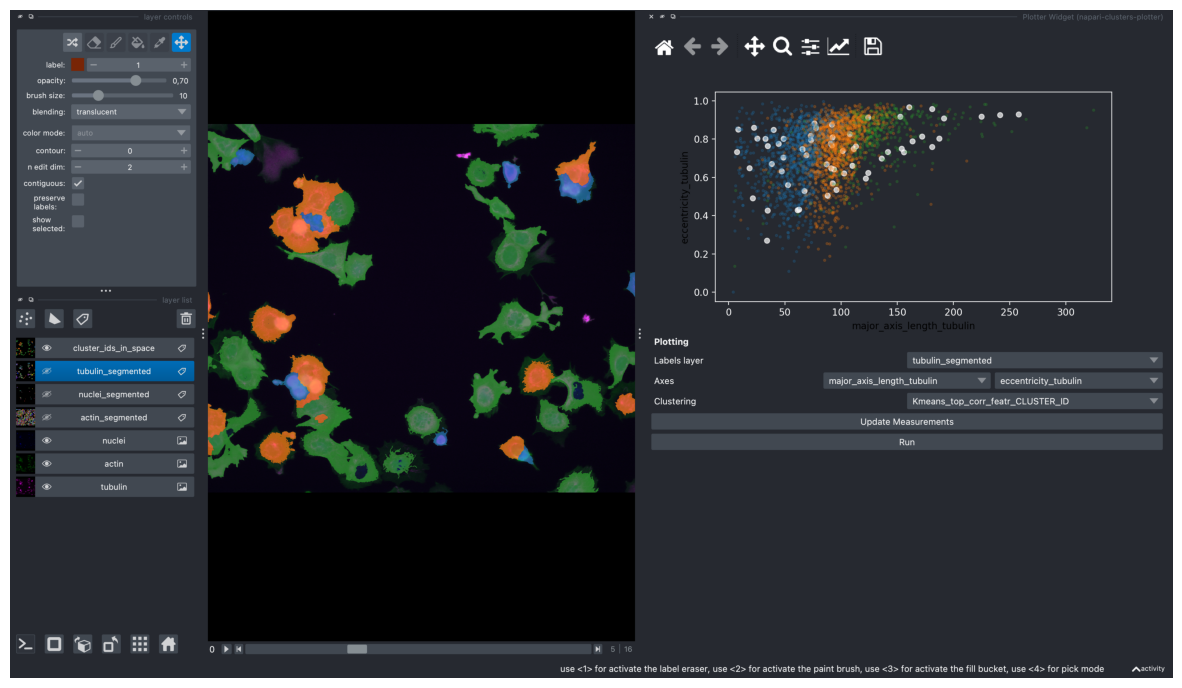

Selected labels layer: tubulin_segmented
Selected measurements: ['area_dapi', 'equivalent_diameter_dapi', 'mean_intensity_dapi', 'min_intensity_dapi', 'max_intensity_dapi', 'perimeter_dapi', 'perimeter_crofton_dapi', 'extent_dapi', 'solidity_dapi', 'feret_diameter_max_dapi', 'major_axis_length_dapi', 'minor_axis_length_dapi', 'eccentricity_dapi', 'orientation_dapi', 'area_actin', 'equivalent_diameter_actin', 'mean_intensity_actin', 'min_intensity_actin', 'max_intensity_actin', 'perimeter_actin', 'perimeter_crofton_actin', 'extent_actin', 'solidity_actin', 'feret_diameter_max_actin', 'major_axis_length_actin', 'minor_axis_length_actin', 'eccentricity_actin', 'orientation_actin', 'area_tubulin', 'equivalent_diameter_tubulin', 'mean_intensity_tubulin', 'min_intensity_tubulin', 'max_intensity_tubulin', 'perimeter_tubulin', 'perimeter_crofton_tubulin', 'extent_tubulin', 'solidity_tubulin', 'feret_diameter_max_tubulin', 'major_axis_length_tubulin', 'minor_axis_length_tubulin', 'eccentricity_

/Users/laura/micromamba/envs/devbio-napari-env/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342
Dimensionality reduction finished


/Users/laura/micromamba/envs/devbio-napari-env/lib/python3.9/site-packages/napari/components/viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,
/Users/laura/micromamba/envs/devbio-napari-env/lib/python3.9/site-packages/napari/utils/_proxies.py:144: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  setattr(self.__wrapped__, name, value)


In [24]:
screenshot = viewer.screenshot(canvas_only=False)

plt.figure(figsize=(15, 10))
plt.imshow(screenshot)
plt.axis('off')
plt.show()